<a href="https://colab.research.google.com/github/pedrov718/classifying_mental_health_with_NN/blob/main/nueral_network_classifyer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
!pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Flatten
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.utils import np_utils
from sklearn import preprocessing
from keras.regularizers import l2

In [39]:
posts = pd.read_excel('/content/mental_health_posts_scraped.xlsx', index_col= 'Unnamed: 0')

In [42]:
posts.rename(columns = {"Origin":'label'}, inplace = True)

In [43]:
labels = pd.get_dummies(posts.label, drop_first= False)

In [44]:
posts = posts.join(labels)

In [45]:
posts.sample(1)

,Title,Post Text,ID,Score,Total Comments,label,Post URL,text,Anxiety,BPD,autism,bipolar,depression,schizophrenia
10188,Getting a graduate student!,Since I have successfully trained a high schoo...,y51221,16,3,schizophrenia,https://www.reddit.com/r/schizophrenia/comment...,Getting a graduate student!Since I have succes...,0,0,0,0,0,1


In [46]:
posts.columns[7:].values

array(['text', 'Anxiety', 'BPD', 'autism', 'bipolar', 'depression',
       'schizophrenia'], dtype=object)

In [47]:
df = posts[posts.columns[7:].values]

In [48]:
df[posts.columns[8:].values].sum()

Anxiety          3119
BPD              3260
autism           3444
bipolar          3272
depression       3301
schizophrenia    3291
dtype: int64

In [49]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [50]:
def df_to_dataset(dataframe, shuffle=True, batch_size=512):
  df = dataframe.copy()
  labels = df[posts.columns[8:].values]
  df = df["text"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

## Embedding our corpus with a pretrained TF HUB model

In [ ]:
!pip install tensorflow_hub

In [ ]:
import tensorflow_hub as hub

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [ ]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(512, 50), dtype=float32, numpy=
array([[ 0.5651446 ,  0.23251829, -0.15642019, ..., -0.8376741 ,
         0.12326983,  0.42253628],
       [ 0.17511241,  0.24413246, -0.26827198, ..., -0.1439221 ,
         0.08626086,  0.16191791],
       [ 0.7160666 , -0.05764601,  0.05330362, ..., -0.5281424 ,
         0.31564188, -0.24860829],
       ...,
       [ 0.31789884, -0.04061145, -0.00556228, ..., -0.14623564,
         0.09523804, -0.11206346],
       [ 0.68985367,  0.11156266, -0.48261714, ..., -0.43086183,
         0.09838626, -0.05855991],
       [ 0.83509547, -0.09995264, -0.57446235, ..., -0.37629935,
        -0.03470805,  0.17377819]], dtype=float32)>

## Creating our word embedded Model

In [ ]:
seq_model = tf.keras.Sequential()
seq_model.add(hub_layer)
seq_model.add(tf.keras.layers.Dense(64, activation='relu'))
seq_model.add(tf.keras.layers.Dropout(0.4))
seq_model.add(tf.keras.layers.Dense(32, activation='relu'))
seq_model.add(tf.keras.layers.Dropout(0.4))
seq_model.add(tf.keras.layers.Dense(16, activation='relu'))
seq_model.add(tf.keras.layers.Dropout(0.4))
seq_model.add(tf.keras.layers.Dense(6, activation='sigmoid'))

In [ ]:
seq_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(), #loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
seq_model.evaluate(train_data)

31/31 [==============================] - 1s 13ms/step - loss: 1.8088 - accuracy: 0.1528


[1.8087652921676636, 0.15283510088920593]

In [ ]:
seq_model.evaluate(valid_data)

4/4 [==============================] - 0s 10ms/step - loss: 1.8134 - accuracy: 0.1559


[1.8133552074432373, 0.1559167057275772]

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights= True)

In [ ]:
history = seq_model.fit(train_data, epochs=1000, validation_data=valid_data, callbacks=[callback])

Epoch 1/1000
31/31 [==============================] - 9s 257ms/step - loss: 1.7991 - accuracy: 0.1787 - val_loss: 1.7811 - val_accuracy: 0.2529
Epoch 2/1000
31/31 [==============================] - 7s 236ms/step - loss: 1.7783 - accuracy: 0.2085 - val_loss: 1.7691 - val_accuracy: 0.2854
Epoch 3/1000
31/31 [==============================] - 7s 239ms/step - loss: 1.7647 - accuracy: 0.2311 - val_loss: 1.7501 - val_accuracy: 0.2981
Epoch 4/1000
31/31 [==============================] - 7s 232ms/step - loss: 1.7408 - accuracy: 0.2622 - val_loss: 1.7110 - val_accuracy: 0.3438
Epoch 5/1000
31/31 [==============================] - 8s 242ms/step - loss: 1.6937 - accuracy: 0.2874 - val_loss: 1.6285 - val_accuracy: 0.3779
Epoch 6/1000
31/31 [==============================] - 7s 232ms/step - loss: 1.6103 - accuracy: 0.3366 - val_loss: 1.5112 - val_accuracy: 0.4063
Epoch 7/1000
31/31 [==============================] - 7s 234ms/step - loss: 1.4993 - accuracy: 0.3890 - val_loss: 1.3943 - val_accuracy:

In [ ]:
seq_model.evaluate(test_data)

4/4 [==============================] - 0s 54ms/step - loss: 10.0777 - accuracy: 0.6470


[10.077653884887695, 0.647028923034668]

In [ ]:
# loading library
import pickle
# create an iterator object with write permission - model.pkl
with open('sequential_classifyer', 'wb') as files:
    pickle.dump(seq_model, files)

INFO:tensorflow:Assets written to: ram://3241f499-bba4-4fad-a30d-93678bce54ed/assets


INFO:tensorflow:Assets written to: ram://3241f499-bba4-4fad-a30d-93678bce54ed/assets


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


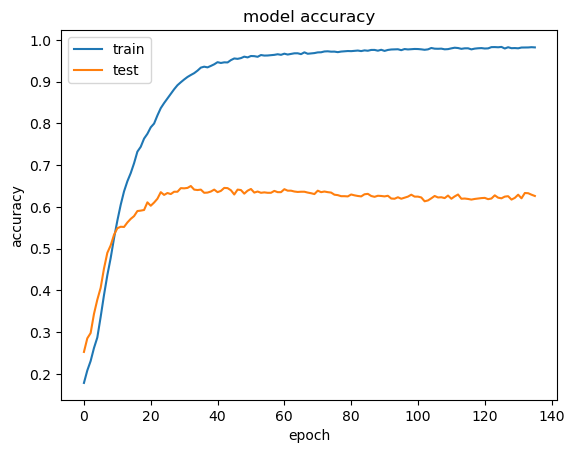

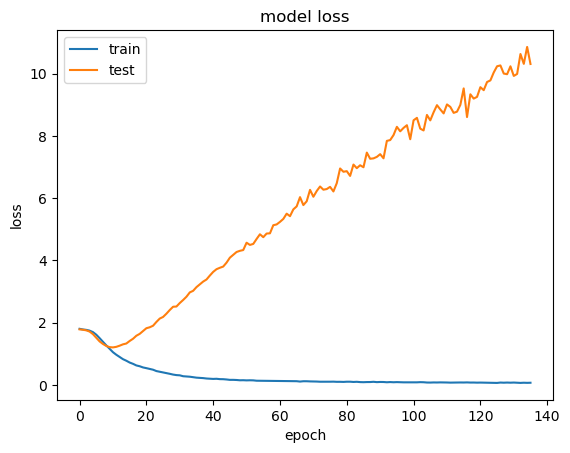

In [ ]:
# list all data in history
print(history.history.keys())


# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Bidirectional LSTM

In [ ]:
train_data = df_to_dataset(train, batch_size= 64)
valid_data = df_to_dataset(val, batch_size= 64)
test_data = df_to_dataset(test, batch_size= 64)

In [ ]:
encoder = tf.keras.layers.TextVectorization(output_mode="int", standardize  = "lower_and_strip_punctuation", max_tokens= 2000, pad_to_max_tokens= True)

encoder.adapt(list(train_data)[0][0])

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]
len(encoder.get_vocabulary())

1963

In [ ]:
bi_lstm = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(6, activation='sigmoid')
])

SyntaxError: invalid syntax (3632677186.py, line 10)

In [ ]:
bi_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
bi_lstm.evaluate(train_data)

bi_lstm.evaluate(valid_data)

31/31 [==============================] - 10s 325ms/step - loss: 1.7919 - accuracy: 0.1605


[1.7919179201126099, 0.160487562417984]

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, restore_best_weights= True)

In [ ]:
history2 = bi_lstm.fit(train_data, epochs=25, validation_data=valid_data, callbacks=[callback])

Epoch 1/25
247/247 [==============================] - 599s 2s/step - loss: 1.2031 - accuracy: 0.5395 - val_loss: 1.0738 - val_accuracy: 0.6084
Epoch 2/25
247/247 [==============================] - 645s 3s/step - loss: 1.0111 - accuracy: 0.6242 - val_loss: 1.0155 - val_accuracy: 0.6272
Epoch 3/25
247/247 [==============================] - 646s 3s/step - loss: 0.9271 - accuracy: 0.6652 - val_loss: 0.9596 - val_accuracy: 0.6384
Epoch 4/25
247/247 [==============================] - 632s 3s/step - loss: 0.8623 - accuracy: 0.6929 - val_loss: 0.9984 - val_accuracy: 0.6496
Epoch 5/25
247/247 [==============================] - 651s 3s/step - loss: 0.7976 - accuracy: 0.7193 - val_loss: 0.9837 - val_accuracy: 0.6506
Epoch 6/25
247/247 [==============================] - 752s 3s/step - loss: 0.7385 - accuracy: 0.7369 - val_loss: 1.0313 - val_accuracy: 0.6557
Epoch 7/25
247/247 [==============================] - 732s 3s/step - loss: 0.6941 - accuracy: 0.7520 - val_loss: 1.0340 - val_accuracy: 0.6562

In [ ]:
bi_lstm.evaluate(test_data)

31/31 [==============================] - 14s 466ms/step - loss: 1.7685 - accuracy: 0.6536


[1.7684904336929321, 0.6536312699317932]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


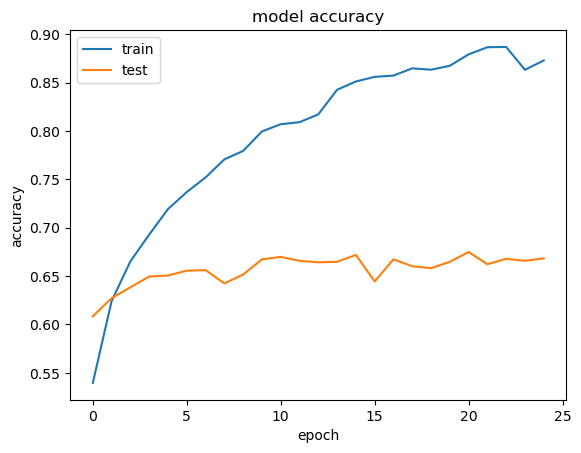

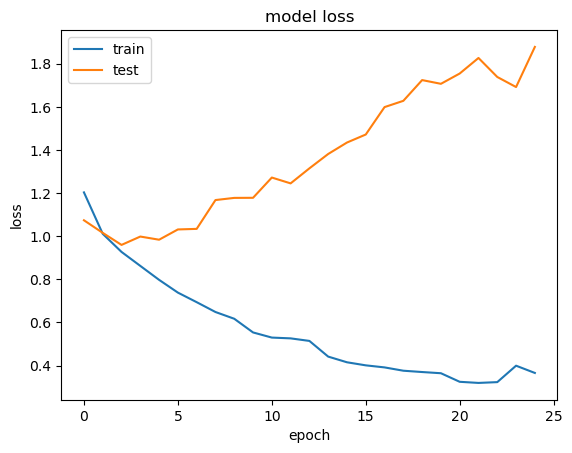

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


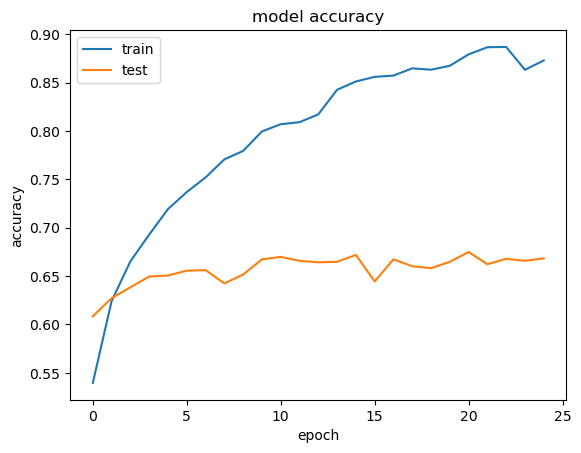

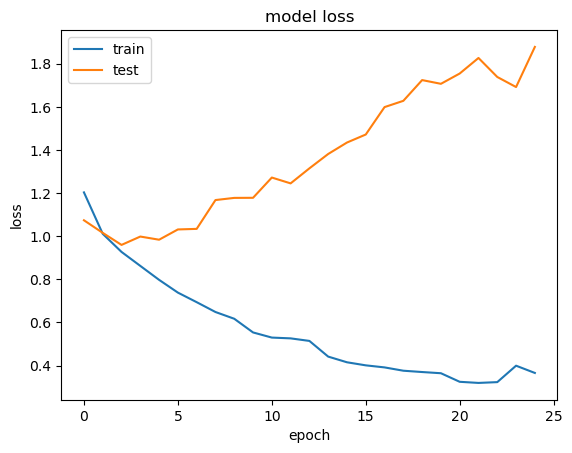

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


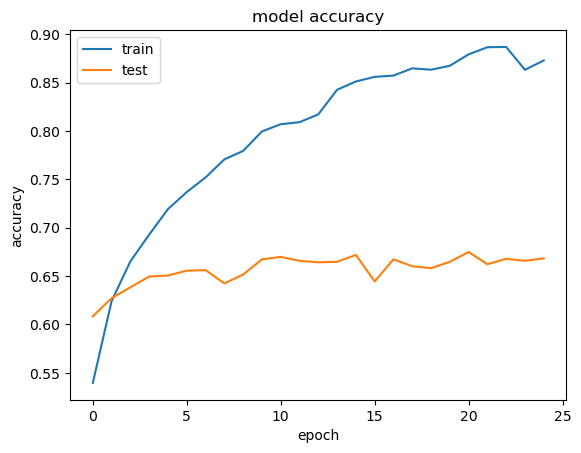

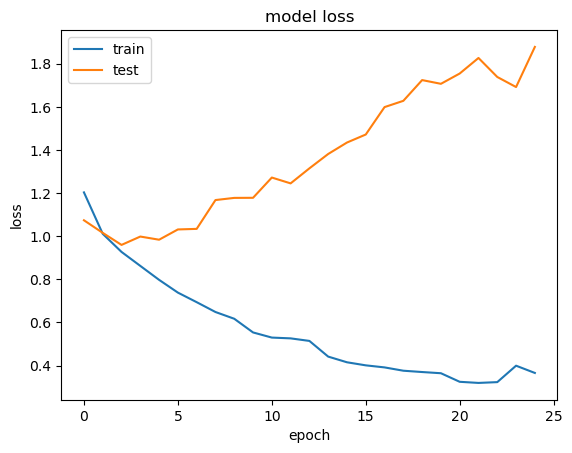

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


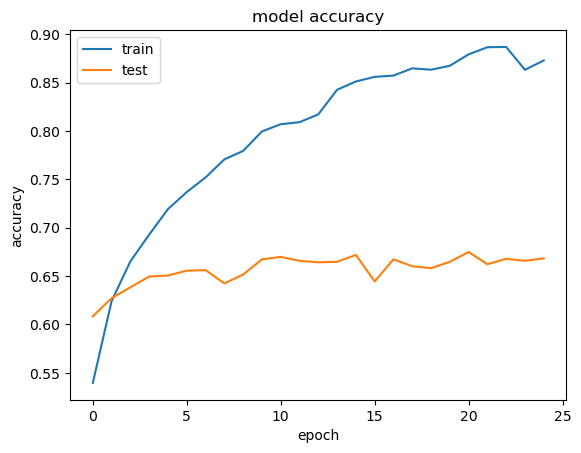

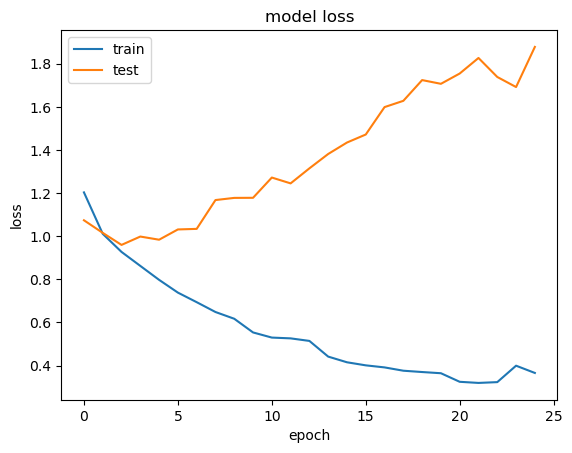

In [ ]:
# list all data in history
print(history2.history.keys())


# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# loading library
import pickle
# create an iterator object with write permission - model.pkl
with open('bidirectional_classifyer', 'wb') as files:
    pickle.dump(bi_lstm, files)

INFO:tensorflow:Assets written to: ram://9be7d1ca-417b-4559-aece-9994c0400458/assets


INFO:tensorflow:Assets written to: ram://9be7d1ca-417b-4559-aece-9994c0400458/assets


## Two Bilsmt

In [51]:
train_data = df_to_dataset(train, batch_size= 64)
valid_data = df_to_dataset(val, batch_size= 64)
test_data = df_to_dataset(test, batch_size= 64)

In [52]:
encoder = tf.keras.layers.TextVectorization(output_mode="int", standardize  = "lower_and_strip_punctuation", max_tokens= 2000, pad_to_max_tokens= True)

encoder.adapt(list(train_data)[0][0])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [53]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]
len(encoder.get_vocabulary())

1751

In [54]:
bi_lstm2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()), output_dim=32,   mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(6, activation='sigmoid')
])

In [55]:
bi_lstm2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [56]:
bi_lstm2.evaluate(train_data)

bi_lstm2.evaluate(valid_data)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
31/31 [==============================] - 4s 119ms/step - loss: 4.2465 - accuracy: 0.1747


[4.246467590332031, 0.17470797896385193]

In [63]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights= True)

In [ ]:
history3 = bi_lstm2.fit(train_data, epochs=100, validation_data=valid_data, callbacks=[callback])

Epoch 1/100
247/247 [==============================] - 146s 591ms/step - loss: 1.1561 - accuracy: 0.5727 - val_loss: 1.3241 - val_accuracy: 0.5373
Epoch 2/100
247/247 [==============================] - 92s 374ms/step - loss: 1.1360 - accuracy: 0.5846 - val_loss: 1.2967 - val_accuracy: 0.5399
Epoch 3/100
247/247 [==============================] - 133s 540ms/step - loss: 1.1450 - accuracy: 0.5784 - val_loss: 1.3021 - val_accuracy: 0.5399
Epoch 4/100
247/247 [==============================] - 91s 367ms/step - loss: 1.1306 - accuracy: 0.5835 - val_loss: 1.2976 - val_accuracy: 0.5389
Epoch 5/100
247/247 [==============================] - 119s 484ms/step - loss: 1.1166 - accuracy: 0.5911 - val_loss: 1.3155 - val_accuracy: 0.5282
Epoch 6/100
247/247 [==============================] - 106s 432ms/step - loss: 1.1203 - accuracy: 0.5912 - val_loss: 1.2910 - val_accuracy: 0.5505
Epoch 7/100
247/247 [==============================] - 120s 488ms/step - loss: 1.1123 - accuracy: 0.5941 - val_loss: 1.2

In [59]:
bi_lstm2.evaluate(test_data)

31/31 [==============================] - 3s 104ms/step - loss: 1.3403 - accuracy: 0.5119


[1.3403464555740356, 0.5119349956512451]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


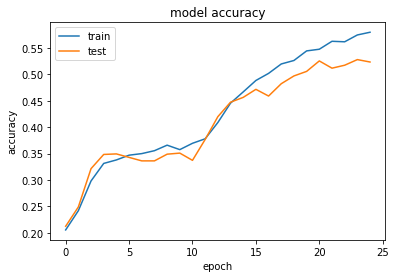

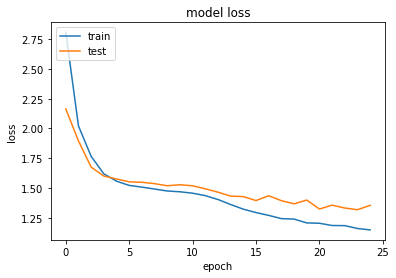

In [60]:
# list all data in history
print(history3.history.keys())


# summarize history for accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [61]:
#%tensorboard --logdir logs/fit

In [62]:
# create an iterator object with write permission - model.pkl
with open('two_bidirectional_classifyer', 'wb') as files:
    pickle.dump(bi_lstm2, files)

NameError: ignored

## Using LIT API to visualize our model

In [ ]:
import sys

from absl import app
from absl import flags
from absl import logging

from lit_nlp import dev_server
from lit_nlp import server_flags
from lit_nlp.api import model as lit_model
from lit_nlp.api import types as lit_types
# Use the regular GLUE data loaders, because these are very simple already.
from lit_nlp.examples.datasets import glue
from lit_nlp.lib import utils

import tensorflow as tf
import transformers

# NOTE: additional flags defined in server_flags.py

FLAGS = flags.FLAGS

FLAGS.set_default("development_demo", True)

flags.DEFINE_string(
    "model_path",
    "https://storage.googleapis.com/what-if-tool-resources/lit-models/sst2_tiny.tar.gz",
    "Path to trained model, in standard transformers format, e.g. as "
    "saved by model.save_pretrained() and tokenizer.save_pretrained()")


def _from_pretrained(cls, *args, **kw):
  """Load a transformers model in TF2, with fallback to PyTorch weights."""
  try:
    return cls.from_pretrained(*args, **kw)
  except OSError as e:
    logging.warning("Caught OSError loading model: %s", e)
    logging.warning(
        "Re-trying to convert from PyTorch checkpoint (from_pt=True)")
    return cls.from_pretrained(*args, from_pt=True, **kw)


class SimpleSentimentModel(lit_model.Model):
  """Simple sentiment analysis model."""

  # LABELS = ["0", "1"]  # negative, positive
  LABELS = ['Anxiety', 'BPD', 'autism', 'bipolar', 'depression',
       'schizophrenia']

  def __init__(self, model_name_or_path):
    self.tokenizer = transformers.AutoTokenizer.from_pretrained(
        model_name_or_path)
    model_config = transformers.AutoConfig.from_pretrained(
        model_name_or_path,
        num_labels=2,
        output_hidden_states=True,
        output_attentions=True,
    )
    # This is a just a regular Keras model.
    self.model = _from_pretrained(
        transformers.TFAutoModelForSequenceClassification,
        model_name_or_path,
        config=model_config)

  ##
  # LIT API implementation
  def max_minibatch_size(self):
    # This tells lit_model.Model.predict() how to batch inputs to
    # predict_minibatch().
    # Alternately, you can just override predict() and handle batching yourself.
    return 32

  def predict_minibatch(self, inputs):
    # Preprocess to ids and masks, and make the input batch.
    encoded_input = self.tokenizer.batch_encode_plus(
        [ex["sentence"] for ex in inputs],
        return_tensors="tf",
        add_special_tokens=True,
        max_length=128,
        padding="longest",
        truncation="longest_first")

    # Run a forward pass.
    out: transformers.modeling_tf_outputs.TFSequenceClassifierOutput = \
        self.model(encoded_input, training=False)

    # Post-process outputs.
    batched_outputs = {
        "probas": tf.nn.softmax(out.logits, axis=-1),
        "input_ids": encoded_input["input_ids"],
        "ntok": tf.reduce_sum(encoded_input["attention_mask"], axis=1),
        "cls_emb": out.hidden_states[-1][:, 0],  # last layer, first token
    }
    # Return as NumPy for further processing.
    detached_outputs = {k: v.numpy() for k, v in batched_outputs.items()}
    # Unbatch outputs so we get one record per input example.
    for output in utils.unbatch_preds(detached_outputs):
      ntok = output.pop("ntok")
      output["tokens"] = self.tokenizer.convert_ids_to_tokens(
          output.pop("input_ids")[1:ntok - 1])
      yield output

  def input_spec(self) -> lit_types.Spec:
    return {
        "sentence": lit_types.TextSegment(),
        "label": lit_types.CategoryLabel(vocab=self.LABELS, required=False)
    }

  def output_spec(self) -> lit_types.Spec:
    return {
        "tokens": lit_types.Tokens(),
        "probas": lit_types.MulticlassPreds(parent="label", vocab=self.LABELS,
                                            null_idx=0),
        "cls_emb": lit_types.Embeddings()
    }


def get_wsgi_app():
  """Returns a LitApp instance for consumption by gunicorn."""
  FLAGS.set_default("server_type", "external")
  FLAGS.set_default("demo_mode", True)
  # Parse flags without calling app.run(main), to avoid conflict with
  # gunicorn command line flags.
  unused = flags.FLAGS(sys.argv, known_only=True)
  return main(unused)


def main(_):
  # Normally path is a directory; if it's an archive file, download and
  # extract to the transformers cache.
  model_path = FLAGS.model_path
  if model_path.endswith(".tar.gz"):
    model_path = transformers.file_utils.cached_path(
        model_path, extract_compressed_file=True)

  # Load the model we defined above.
  models = {"sst": SimpleSentimentModel(model_path)}
  # Load SST-2 validation set from TFDS.
  datasets = {"sst_dev": glue.SST2Data("validation")}

  # Start the LIT server. See server_flags.py for server options.
  lit_demo = dev_server.Server(models, datasets, **server_flags.get_flags())
  return lit_demo.serve()


if __name__ == "__main__":
  app.run(main)